# SIR
----


## Bibliotecas

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import deepxde as dde

In [10]:
# Para reprodução dos experimentos
dde.config.set_random_seed(1000)

## Modelo SIR

$$
\frac{dS}{dt} = −βSI
$$
$$
\frac{dI}{dt} = βSI − γI
$$
$$
\frac{dR}{dt} = γI.
$$

In [11]:
beta = 1.5
gamma = 0.8

In [12]:
def sir_model(t, y):

    S, I, R = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)
    
    return [
        dS_dt - (-beta * S * I),
        dI_dt - (beta * S * I - gamma * I),
        dR_dt - (gamma * I)   
    ]

## Limites

In [13]:
t0, tf = 0, 50
geom = dde.geometry.TimeDomain(t0, tf)

## Condições iniciais

In [14]:
S0 = 0.99
I0 = 0.01
R0 = 0.00

ic_S = dde.icbc.IC(geom, lambda _: S0, lambda _, on_initial: on_initial, component=0)
ic_I = dde.icbc.IC(geom, lambda _: I0, lambda _, on_initial: on_initial, component=1)
ic_R = dde.icbc.IC(geom, lambda _: R0, lambda _, on_initial: on_initial, component=2)

## Dados de treinamento

In [15]:
data = dde.data.PDE(
    geom, 
    sir_model, 
    [ic_S, ic_I, ic_R],
    num_domain=100, 
    num_boundary=2)

## Configuração da rede

In [16]:
net = dde.nn.FNN([1] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

Compiling model...
'compile' took 0.000193 s



## Treinamento

In [17]:
losshistory, train_state = model.train(
    iterations=20000, 
    model_save_path="../modelos/sir")

dde.saveplot(
    losshistory, 
    train_state, 
    output_dir="../treinamentos",
    loss_fname="sir_losses.dat",
    train_fname="sir_train.dat",
    test_fname="sir_test.dat",
    issave=True, 
    isplot=False)

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.72e-01, 1.58e+00, 3.17e-01, 9.80e-01, 1.00e-04, 0.00e+00]    [4.72e-01, 1.58e+00, 3.17e-01, 9.80e-01, 1.00e-04, 0.00e+00]    []  
1000      [2.02e-05, 1.83e-05, 3.64e-06, 2.73e-09, 1.75e-07, 1.00e-10]    [2.02e-05, 1.83e-05, 3.64e-06, 2.73e-09, 1.75e-07, 1.00e-10]    []  
2000      [1.05e-05, 1.01e-05, 3.37e-07, 9.90e-10, 1.52e-07, 2.80e-12]    [1.05e-05, 1.01e-05, 3.37e-07, 9.90e-10, 1.52e-07, 2.80e-12]    []  
3000      [6.75e-06, 6.74e-06, 1.02e-07, 4.13e-10, 1.41e-07, 1.80e-14]    [6.75e-06, 6.74e-06, 1.02e-07, 4.13e-10, 1.41e-07, 1.80e-14]    []  
4000      [4.97e-06, 9.11e-06, 1.13e-07, 9.28e-10, 1.07e-07, 2.74e-13]    [4.97e-06, 9.11e-06, 1.13e-07, 9.28e-10, 1.07e-07, 2.74e-13]    []  
5000      [3.43e-06, 1.24e-05, 1.07e-07, 2.04e-09, 7.05e-08, 2.25e-10]    [3.43e-06, 1.24e-05, 1.07e-07, 2.04e-09, 7

## Visualizando resultados

In [18]:
def plot_and_save_solution(solution, t_test, file_path):

    S, I, R = solution[:, 0], solution[:, 1], solution[:, 2]

    plt.plot(t_test, S, label="Suscetíveis (S)", linewidth=5)
    plt.plot(t_test, I, label="Infectados (I)", linewidth=5)
    plt.plot(t_test, R, label="Recuperados (R)", linewidth=5)
    
    plt.xlabel("Tempo (t)")
    plt.ylabel("Fração da População")
    
    plt.legend()
    plt.grid()
    plt.savefig(file_path)
    plt.show()

In [108]:
model.restore("../modelos/sir-20000.pt")

In [109]:
NUMBER_OF_POINTS = 100

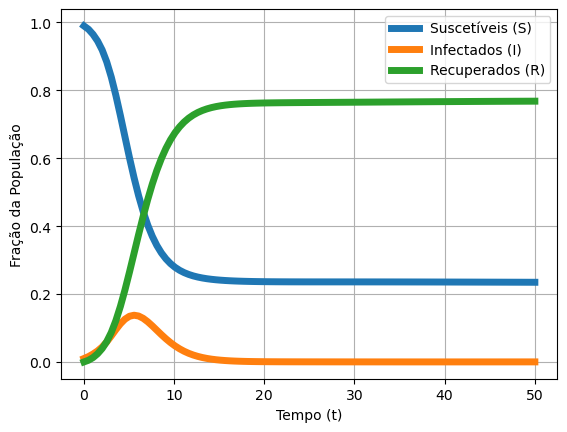

In [110]:
t_test = np.linspace(t0, tf, NUMBER_OF_POINTS)
y_pred = model.predict(t_test.reshape(-1, 1))
plot_and_save_solution(y_pred, t_test, "../figuras/sir_pinn.pdf")

## Comparação com métodos numéricos

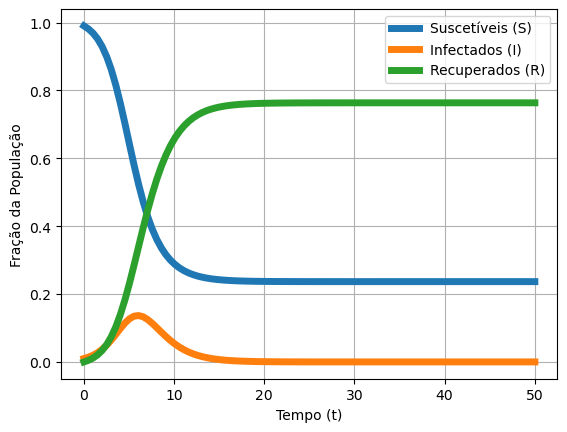

In [111]:

# Modelo SIR: dS/dt = -β S I, dI/dt = β S I - μ I, dR/dt = μ I
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return np.array([dSdt, dIdt, dRdt])

# Implementação do método RK4
def rk4(f, y0, t, beta, gama):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        dt = t[i+1] - t[i]
        k1 = f(y[i], t[i], beta, gama)
        k2 = f(y[i] + dt * k1 / 2, t[i] + dt / 2, beta, gamma)
        k3 = f(y[i] + dt * k2 / 2, t[i] + dt / 2, beta, gamma)
        k4 = f(y[i] + dt * k3, t[i] + dt, beta, gamma)
        y[i+1] = y[i] + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

    return y

# Condições iniciais
y0 = np.array([S0, I0, R0])

# Intervalo de tempo
t = np.linspace(t0, tf, NUMBER_OF_POINTS)  # De 0 a 50, com 100 pontos

# Resolver o sistema SIR com RK4
sol = rk4(sir_model, y0, t, beta, gamma)

plot_and_save_solution(sol, t, "../figuras/sir_rk4.pdf")

# Analisando função de perda

In [112]:
def plot_and_save_losses(losshistory, file_path):
    
    plt.semilogy(losshistory.steps, np.sum(losshistory.loss_train, axis=1), label="Treinamento", linewidth=5)
    plt.semilogy(losshistory.steps, np.sum(losshistory.loss_test, axis=1), label="Teste", linewidth=5)
    
    plt.xlabel("Iteração")
    
    plt.legend()
    plt.grid()
    plt.savefig(file_path)
    plt.show()

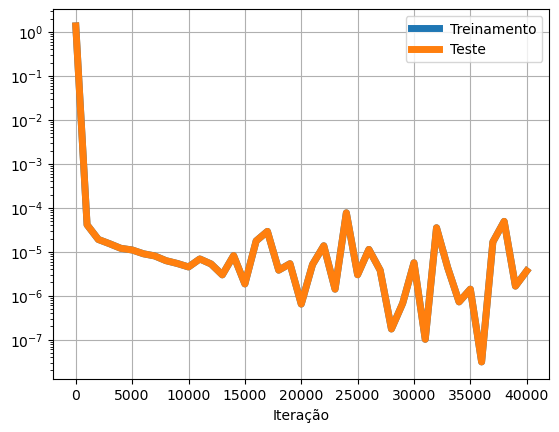

In [113]:
plot_and_save_losses(losshistory, "../figuras/sir_loss.pdf")

In [19]:
train_state.